How does a developer view their own capabilities when we consider their years of experience and their gender? It is commonly held that men tend to rate their own abilities as higher than women would even with the same number of years of experience. While this subset of working people is focused on developers, students, or other professionals utilizing some amount of programming, it will be interesting to see how this holds up.

The survey provides the gender as more than just two options (man, woman, and several other options including queer and non-binary) - to simplify the comparisons and bound this to just 3 options, non-binary will be used when a respondent did not use Man or Woman.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
%matplotlib inline

# Read in the 2020 results and schema as a test to ensure all is correctly organized and the data can be found.
df = pd.read_csv('../developer_survey_2019/survey_results_public.csv')
schema = pd.read_csv('../developer_survey_2019/survey_results_schema.csv')


Here we will reduce the dataset to the primary columns for Gender, SelfAssessed Capabilities (ImpSyn), and Years of Coding experience.

In [3]:
df = df[['Gender','ImpSyn','YearsCode']]


In [4]:


def dummy_gender(df):
    '''
    Summary - This function handles the multi-select options for any response that is not just Man or Woman. 
    Some respondents used Man or Woman in conjunction with several other identifiers. These, along with those 
    the did not use just Man or Woman, are grouped as Non-Binary ('NB')
    INPUT 
        df - Dataframe containing a column of Gender responses and other data
        
    OUTPUT
        new_df - Datafram containing the non-Gender columns from df with a simplified Gender response column.
    '''
    #Initialize a dataframe to hold all the simplified choices
    new_df = df
    gender = [None] * len(df['Gender'])
    
    #loop over the entire Gender column and replace with a simplified string
    for idx in range(0, len(df['Gender'])):
        if df['Gender'][idx] == 'Man':
            gender[idx] = 'Man'
        elif df['Gender'][idx] == 'Woman':
            gender[idx] = 'Woman'
        else:
            gender[idx] = 'NB'
    #Replace he old multi-select column by converting 'gender' into a series and inserting into the dataframe.
    new_df = new_df.drop(['Gender'], axis=1)
    new_df['Gender'] = pd.Series(gender).values
    return new_df


In [6]:

def dummy_SelfAssess_and_remove_NA(df):
    '''
    Summary - This function creates a numeric version of the string for SelfAssessment on the scale 1-5.
    INPUT 
        df - Dataframe containing a column of ImpSyn (Self Assessed Capability score) responses and other data
        
    OUTPUT
        new_df - Datafram containing the numeric score instead. columns from df with a simplified Self-Assessed
        Capability response column.
    '''
    #Drop any rows with nan in the response (ImpSyn) and reset the index
    temp_df = df.dropna(subset=['ImpSyn'], axis=0)
    temp_df = temp_df.reset_index(drop=True)
    #possible_capability = find_unique_entries(df[['ImpSyn']])
    #Create the dictionary for ratings
    weighted_capability = {'Far below average' : 1, 'A little below average' : 2,
                             'Average' : 3, 'A little above average' : 4,
                             'Far above average' : 5}
    #Initialize the list of assessments
    selfAssess = [None] * len(temp_df[['ImpSyn']])
    s = temp_df['ImpSyn']
    
    #Loop over the length of the dataframe and determine the assessment score given the string
    for idx in range(0, len(s)):
        selfAssess[idx] = weighted_capability[s[idx]]
    
    #Update the real dataframe
    temp_df['ImpSyn'] = pd.Series(selfAssess).values
    return temp_df


The first thing we need to do is clean up the data columns - we can do this by calling our "dummy" functions. These aren't exactly traditional Pandas Dummy functions, but they help make the data usable when it's a messy set.

Call dummy_SelfAssess_and_remove_NA to both clean up the response column from nan and convert it to numerics that are correctly ordered.

Call dummy_gender to simplify the gender responses so we have consistent values to work with.

In [7]:
new_df = dummy_SelfAssess_and_remove_NA(df)
new_df = dummy_gender(new_df)


We also now need to clean up the <1 and >50 categories that are strings, not ints. For the purposes of this analysis, <1 year can be said to be 0 while >50 can be 51. Clearly there can be many more categories (51, 52, 53...), but this bound should be sufficient to describe the number of individuals in the data.

In [8]:
new_df['YearsCode'] = new_df['YearsCode'].replace(['Less than 1 year'],0)
new_df['YearsCode'] = new_df['YearsCode'].replace(['More than 50 years'],51)


Now that all of that is taken care of, we can move onto more re-organizing! Let's now split out the genders to better sort them, percentile them, etc. 

In [44]:

def clean_gender(df, gender_string):
     '''
    Summary - This fucntion takes the dataframe and a specific gender and then pulls that gender's data out.
    INPUT 
        df - Dataframe containing a column of ImpSyn (Self Assessed Capability score) responses and other data
        gender_string - String of a simplified gender response (Man, Woman, NB)
        
    OUTPUT
        gen_df - Dataframe containing the specified gender's reponses. Years are cleaned and nans are filled with mean.
        gen_df_groups - Dataframe that groups Gendered data into unique ImpySyn and Years of Experience pairs.
    '''
    gen_df = df[df['Gender'] == gender_string]
    gen_df = gen_df.drop(['Gender'],axis=1)
    gen_df = gen_df.reset_index(drop=True)
    
    # Grab the years of coding experience and fix the nans
    # Use "mean" to fill in the nans as the data is heavily skewed toward the lower years of experience.
    # Min would drive this further while Max cause a shift at the high end which is logically less densely populated.
    # We have valuable data in the gender and ImpSyn columns we do not wish to lose so the data cannot just be removed.
    gen_df['YearsCode'] = gen_df['YearsCode'].astype('float')
    gen_df['YearsCode'].fillna((gen_df['YearsCode'].mean()), inplace=True)
        
    #Group into similar assessment scores X years of experience so individuals that have 10 years
    # of experience and rated themselves as a 4 (A little above average) are counted in one group, for example.
    gen_df_groups = gen_df.groupby(["ImpSyn", "YearsCode"]).size().reset_index(name="Time")
    
    return gen_df, gen_df_groups
#temp, temp_groups = clean_gender(new_df, 'Woman')


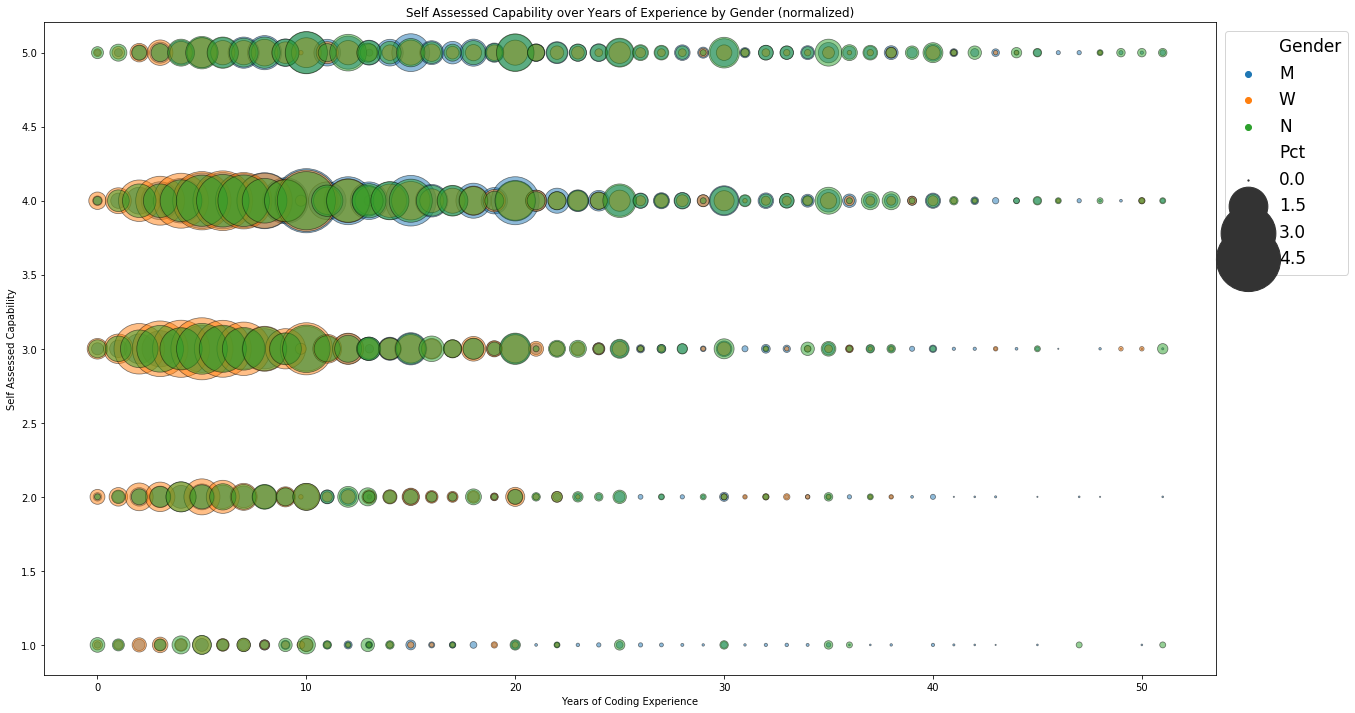

In [92]:
def plot_bubble_pct(df, title='Self-Assessment of Capability by Gener and Years of Experience', plot=True):
    '''
    Summary - The function generates a plot of Capability Score by Years of Experience and overlays the gendered 
    data as percentages of the gender population.
    INPUT 
        df - Dataframe containing a column of ImpSyn (Self Assessed Capability score) years of experience, and gender responses.
        title - default title for the plot
        plot - defaulted input to generate a plot
        
    OUTPUT
        n/a
    '''
    #split out each gender to get the isolated counts of Assessment scores X Years of Experience
    # Remove nans and impute with the mean.
    mdf, mdf_grouped = clean_gender(df, 'Man')
    wdf, wdf_grouped = clean_gender(df, 'Woman')
    ndf, ndf_grouped = clean_gender(df, 'NB')
    
    #Re-stack the isolated genders to facilitate seaborn's Bubble plot
    #Make each df have a column for Gender of the correct size
    mdf_grouped['Gender'] = ['M'] * len(mdf_grouped)
    wdf_grouped['Gender'] = ['W'] * len(wdf_grouped)
    ndf_grouped['Gender'] = ['N'] * len(ndf_grouped)
    
    #get Percents for within each gender and store as a new column
    mdf_grouped['Pct'] = mdf_grouped['Time']/sum(mdf_grouped['Time'])*100
    wdf_grouped['Pct'] = wdf_grouped['Time']/sum(wdf_grouped['Time'])*100
    ndf_grouped['Pct'] = ndf_grouped['Time']/sum(ndf_grouped['Time'])*100
    
    #Gather in one DF for Seaborn.
    temp_group = mdf_grouped
    temp_group = temp_group.append(wdf_grouped)
    temp_group = temp_group.append(ndf_grouped)
    
    #Determine the right bounds for the bubble sizes and adjust up so they are readible.
    minimum = temp_group['Pct'].min()*1000
    maximum = temp_group['Pct'].max()*1000

    plt.figure(figsize=(21, 12))
    #Seabord takes:
    #The df as its data, the x and y argo are assigned as the two columns we are basing this on,
    #Size becomes the number of times a respondent said they had X years of experience and rated themselves as Y after is has been normalized into a percentile of the gender,
    #Hue takes the new sorted Gender column to change colors as that data changes.
    ax = sns.scatterplot(data=temp_group, x="YearsCode", y="ImpSyn", size="Pct", hue="Gender", alpha=0.5, legend='brief', sizes=(minimum, maximum),edgecolor='black')
    plt.xlabel("Years of Coding Experience")
    plt.ylabel("Self Assessed Capability")
    ax.set_title("Self Assessed Capability over Years of Experience by Gender (normalized)")
    plt.legend(labels=['Men', 'Women', 'Non-Binary'])
    plt.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=17)
plot_bubble_pct(new_df)


In the above plot, we can see a similar trend in how people score themselves regardless of gender. Remember, each bubble represents the percent of the gender population (Men-in-category / Total-Men, for example) so the comparison between genders is not skewed by the smaller population sizes of women/non-binary as compared to men. What is interesting is the clusters on the lower-experience (left) side of the plot. Here, we see very similar percentages of the populations rating themselves in the same categories. Our hypothesis was that men were more likely to rate themselves highly regardless of experience level. At th lowest experience levels, we see a higher percentage of the non-binary respondents with scores of 5 and more of women with scores of 4. These are both quickly overtaken as just a few years in, the percentage of men who rate themselves higher increases. Further, men seem to be more present in the data as years of experience is greater.

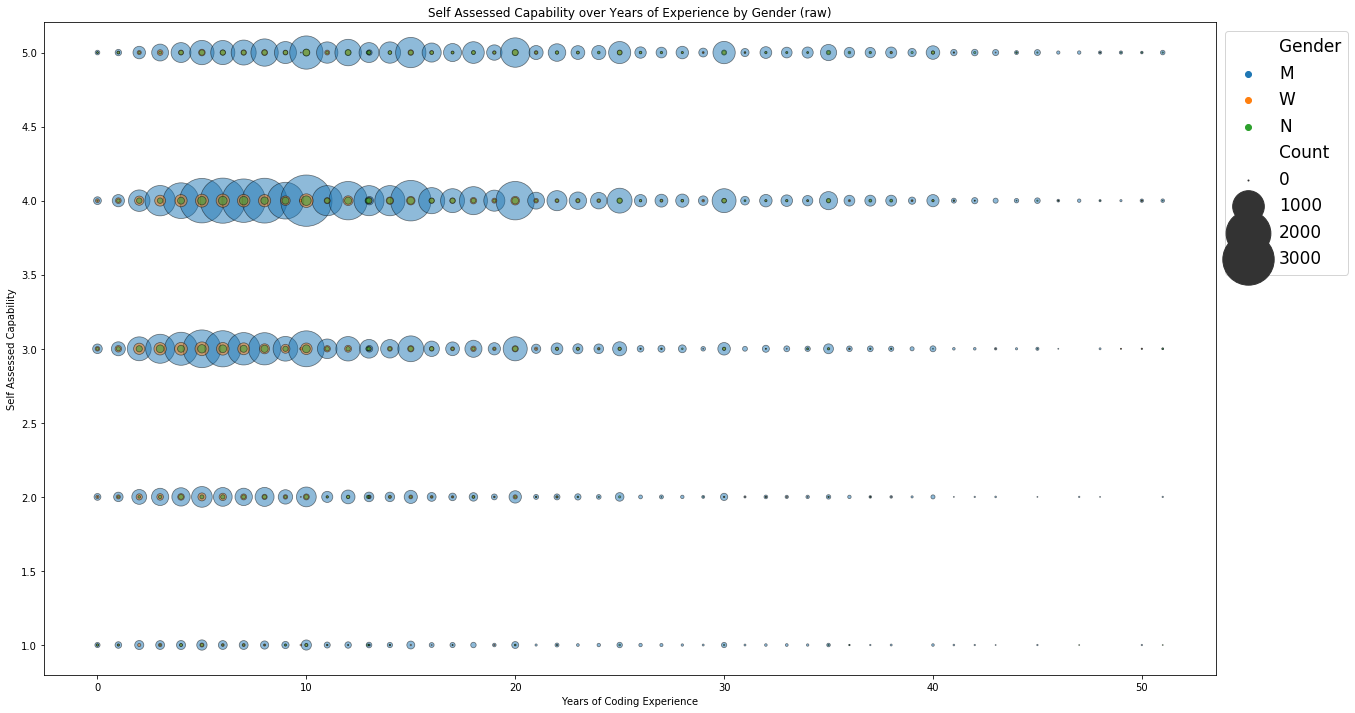

In [95]:
def plot_bubble_raw(df, title='Self-Assessment of Capability by Gener and Years of Experience', plot=True):
    '''
    Summary - The function generates a plot of Capability Score by Years of Experience and overlays the gendered 
    data as raw counts of the gender population.
    INPUT 
        df - Dataframe containing a column of ImpSyn (Self Assessed Capability score) years of experience, and gender responses.
        title - default title for the plot
        plot - defaulted input to generate a plot
        
    OUTPUT
        n/a
    '''
   #split out each gender to get the isolated counts of Assessment scores X Years of Experience
    # Remove nans and impute with the mean.
    mdf, mdf_grouped = clean_gender(df, 'Man')
    wdf, wdf_grouped = clean_gender(df, 'Woman')
    ndf, ndf_grouped = clean_gender(df, 'NB')
    
    #Re-stack the isolated genders to facilitate seaborn's Bubble plot
    #Make each df have a column for Gender of the correct size
    mdf_grouped['Gender'] = ['M'] * len(mdf_grouped)
    wdf_grouped['Gender'] = ['W'] * len(wdf_grouped)
    ndf_grouped['Gender'] = ['N'] * len(ndf_grouped)
    
    #Gather in one DF for Seaborn.
    temp_group = mdf_grouped
    temp_group = temp_group.append(wdf_grouped)
    temp_group = temp_group.append(ndf_grouped)
    temp_group['Count'] = temp_group['Time']
    
    #Determine the right bounds for the bubble sizes and adjust up so they are readible.
    minimum = temp_group['Count'].min()
    maximum = temp_group['Count'].max()

    plt.figure(figsize=(21, 12))
    
    #Seabord takes the df as its data, the x and y argo are assigned as the two columns we are basing this on,
    #size becomes the number of times a respondent said they had X years of experience and rated themselves as Y
    #hue takes the new sorted Gender column to change colors as that data changes.
    ax = sns.scatterplot(data=temp_group, x="YearsCode", y="ImpSyn", size="Count", hue="Gender", alpha=0.5, legend='brief', sizes=(minimum, maximum),edgecolor='black')
    plt.xlabel("Years of Coding Experience")
    plt.ylabel("Self Assessed Capability")
    ax.set_title("Self Assessed Capability over Years of Experience by Gender (raw)")
    ax.legend(labels=['Men', 'Women', 'Non-Binary'])
    ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=17)
plot_bubble_raw(new_df)


Just to throw another viewpoint in, this is a plot of the raw data - you can see a significant delta between the number of respondents by gender. In almost every category, men drastically outweigh women. This is more of a reminder of the disparate population sizes rather than to make any other point. We clearly have a harder time saying "men rate themselves higher more often", but we can say that there is certainly a large population of each gender that views themselves as more than just average at the lower years of experience. It is also interesting to note how there are several people who rated themselves well below average with significant years of experience.

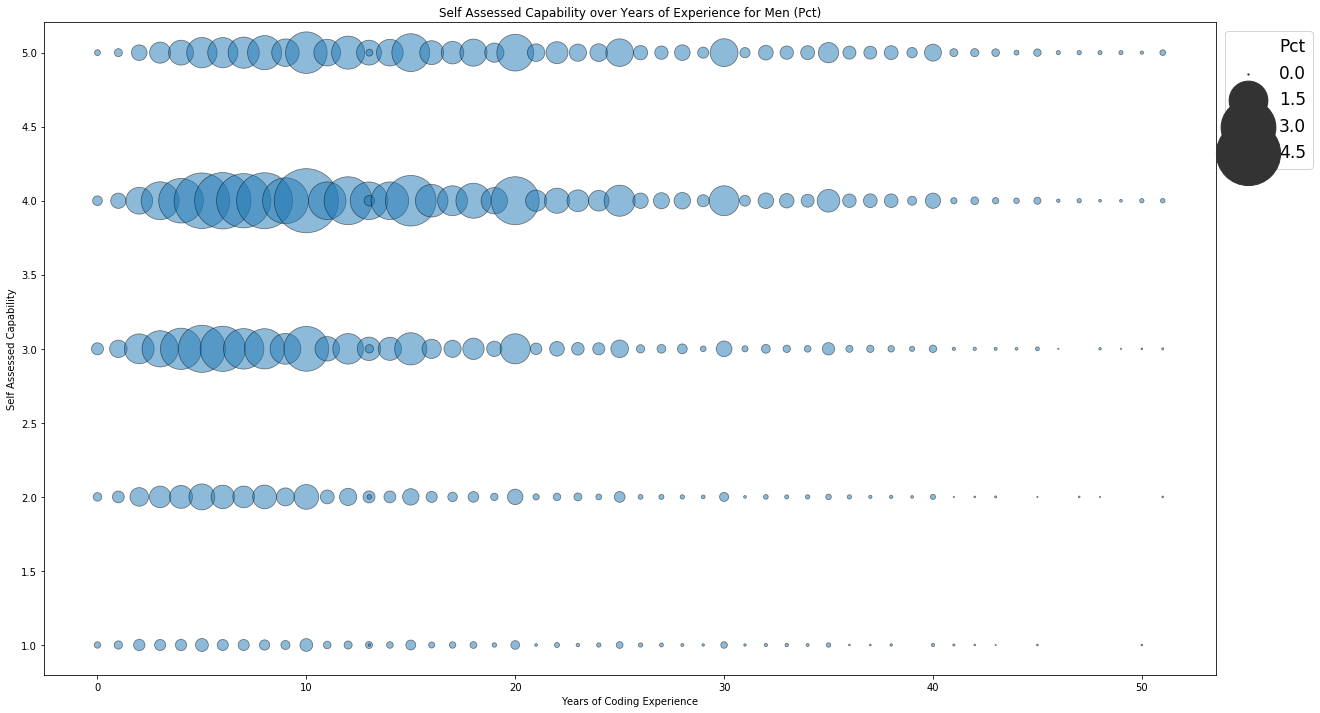

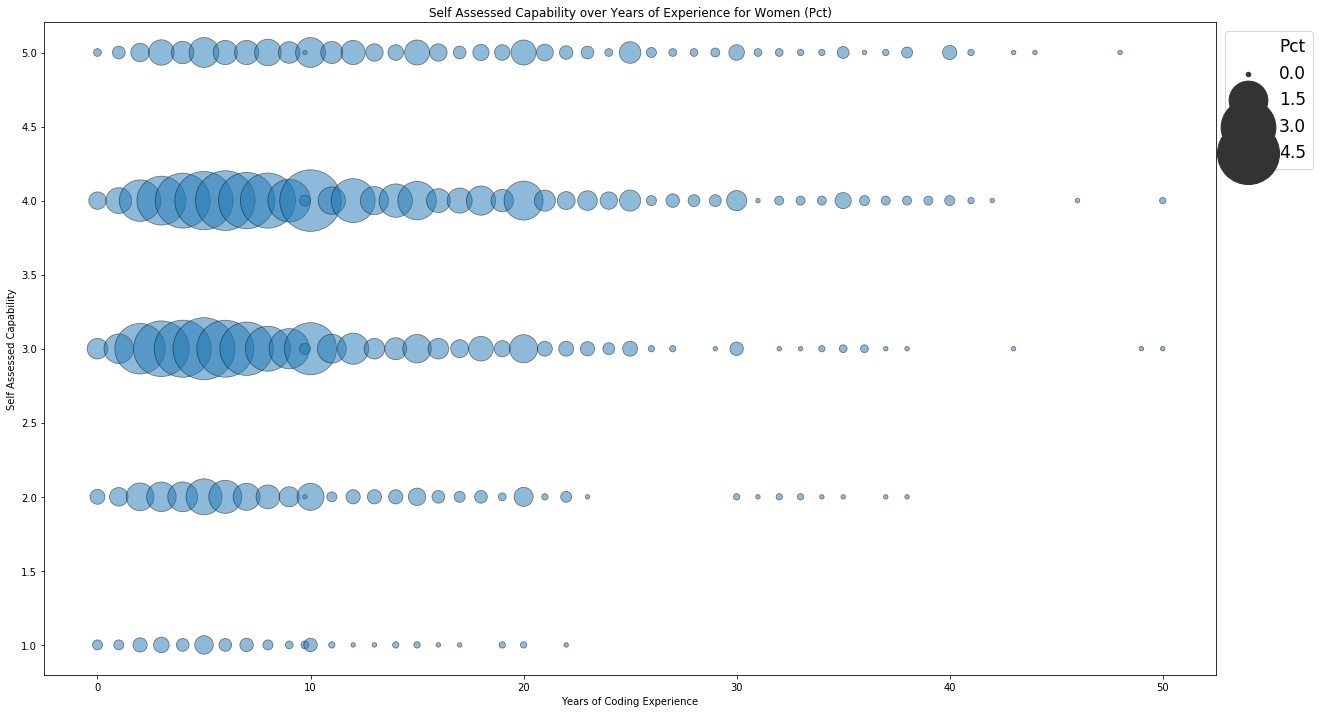

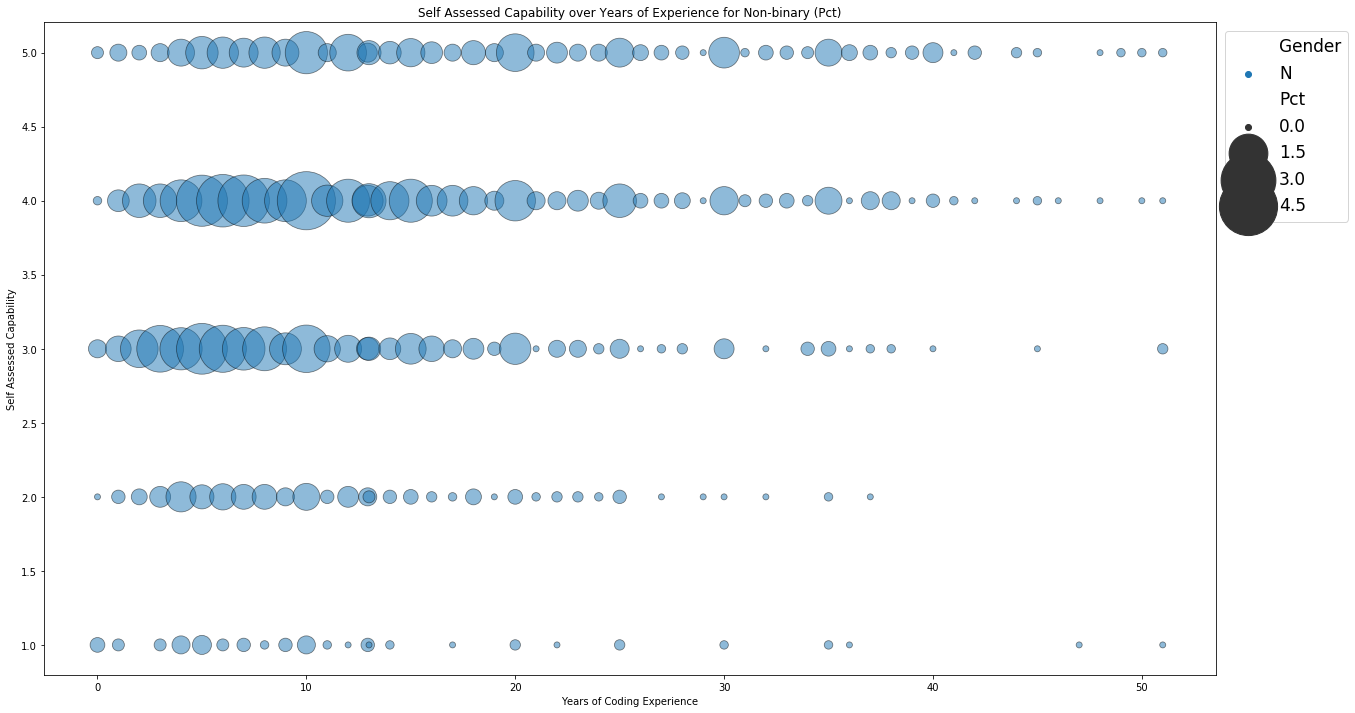

In [97]:
def plot_bubblesM(df, title='Self-Assessment of Capability for Men and Years of Experience', plot=True):
    '''
    Summary - The function generates a plot of Capability Score by Years of Experience and overlays the gendered 
    data as percentages of the gender population. This is specifically men.
    INPUT 
        df - Dataframe containing a column of ImpSyn (Self Assessed Capability score) years of experience, and gender responses.
        title - default title for the plot
        plot - defaulted input to generate a plot
        
    OUTPUT
        n/a
    '''
   #split out each gender to get the isolated counts of Assessment scores X Years of Experience
    # Remove nans and impute with the mean.
    mdf, mdf_grouped = clean_gender(df, 'Man')
   
    #Re-stack the isolated genders to facilitate seaborn's Bubble plot
    #Make each df have a column for Gender of the correct size
    mdf_grouped['Gender'] = ['M'] * len(mdf_grouped)
    
    mdf_grouped['Pct'] = mdf_grouped['Time']/sum(mdf_grouped['Time'])*100
    
    #Gather in one DF for Seaborn.
    temp_group = mdf_grouped
    temp_group['Count'] = temp_group['Time']
    
    #Determine the right bounds for the bubble sizes and adjust up so they are readible.
    minimum = temp_group['Pct'].min()*1000
    maximum = temp_group['Pct'].max()*1000

    plt.figure(figsize=(21, 12))
    
    #Seabord takes the df as its data, the x and y argo are assigned as the two columns we are basing this on,
    #size becomes the number of times a respondent said they had X years of experience and rated themselves as Y
    #hue takes the new sorted Gender column to change colors as that data changes.
    ax = sns.scatterplot(data=temp_group, x="YearsCode", y="ImpSyn", size="Pct", alpha=0.5, legend='brief', sizes=(minimum, maximum),edgecolor='black')
    plt.xlabel("Years of Coding Experience")
    plt.ylabel("Self Assessed Capability")
    ax.set_title("Self Assessed Capability over Years of Experience for Men (Pct)")
    ax.legend(labels=['Men'])
    ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=17)
plot_bubblesM(new_df)
def plot_bubblesW(df, title='Self-Assessment of Capability for Women and Years of Experience', plot=True):
    '''
    Summary - The function generates a plot of Capability Score by Years of Experience and overlays the gendered 
    data as percentages of the gender population. This is specifically women.
    INPUT 
        df - Dataframe containing a column of ImpSyn (Self Assessed Capability score) years of experience, and gender responses.
        title - default title for the plot
        plot - defaulted input to generate a plot
        
    OUTPUT
        n/a
    '''
   #split out each gender to get the isolated counts of Assessment scores X Years of Experience
    # Remove nans and impute with the mean.
    wdf, wdf_grouped = clean_gender(df, 'Woman')    
    #Re-stack the isolated genders to facilitate seaborn's Bubble plot
    #Make each df have a column for Gender of the correct size
    wdf_grouped['Gender'] = ['W'] * len(wdf_grouped)
    wdf_grouped['Pct'] = wdf_grouped['Time']/sum(wdf_grouped['Time'])*100
    
    #Gather in one DF for Seaborn.
    temp_group = wdf_grouped
    temp_group['Count'] = temp_group['Time']
    
    #Determine the right bounds for the bubble sizes and adjust up so they are readible.
    minimum = temp_group['Pct'].min()*1000
    maximum = temp_group['Pct'].max()*1000

    plt.figure(figsize=(21, 12))
    
    #Seabord takes the df as its data, the x and y argo are assigned as the two columns we are basing this on,
    #size becomes the number of times a respondent said they had X years of experience and rated themselves as Y
    #hue takes the new sorted Gender column to change colors as that data changes.
    ax = sns.scatterplot(data=temp_group, x="YearsCode", y="ImpSyn", size="Pct", alpha=0.5, legend='brief', sizes=(minimum, maximum),edgecolor='black')
    plt.xlabel("Years of Coding Experience")
    plt.ylabel("Self Assessed Capability")
    ax.set_title("Self Assessed Capability over Years of Experience for Women (Pct)")
    ax.legend(labels=['Women'])
    ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=17)
plot_bubblesW(new_df)

def plot_bubblesN(df, title='Self-Assessment of Capability for Non-Binary and Years of Experience', plot=True):
    '''
    Summary - The function generates a plot of Capability Score by Years of Experience and overlays the gendered 
    data as percentages of the gender population. This is specifically non-binary.
    INPUT 
        df - Dataframe containing a column of ImpSyn (Self Assessed Capability score) years of experience, and gender responses.
        title - default title for the plot
        plot - defaulted input to generate a plot
        
    OUTPUT
        n/a
    '''
   #split out each gender to get the isolated counts of Assessment scores X Years of Experience
    # Remove nans and impute with the mean.
    ndf, ndf_grouped = clean_gender(df, 'NB')
    
    #Re-stack the isolated genders to facilitate seaborn's Bubble plot
    #Make each df have a column for Gender of the correct size
    ndf_grouped['Gender'] = ['N'] * len(ndf_grouped)
    ndf_grouped['Pct'] = ndf_grouped['Time']/sum(ndf_grouped['Time'])*100
    
    #Gather in one DF for Seaborn.
    temp_group = ndf_grouped
    temp_group['Count'] = temp_group['Time']
    
    #Determine the right bounds for the bubble sizes and adjust up so they are readible.
    minimum = temp_group['Pct'].min()*1000
    maximum = temp_group['Pct'].max()*1000

    plt.figure(figsize=(21, 12))
    
    #Seabord takes the df as its data, the x and y argo are assigned as the two columns we are basing this on,
    #size becomes the number of times a respondent said they had X years of experience and rated themselves as Y
    #hue takes the new sorted Gender column to change colors as that data changes.
    ax = sns.scatterplot(data=temp_group, x="YearsCode", y="ImpSyn", size="Pct", hue="Gender", alpha=0.5, legend='brief', sizes=(minimum, maximum),edgecolor='black')
    plt.xlabel("Years of Coding Experience")
    plt.ylabel("Self Assessed Capability")
    ax.set_title("Self Assessed Capability over Years of Experience for Non-binary (Pct)")
    ax.legend(labels=['Men', 'Women', 'Non-Binary'])
    ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=17)
plot_bubblesN(new_df)


The above three charts demonstrate the percentiles of each gender on their own chart to let them stand apart for better inspection. The first thing to note is a larger percentage of women will rate themselves in the 3-4 category for the 0-10 years of experience range as compared men who have fairly even, but high percentages for scores at 3-5. This shows men do rate themselves higher more frequently, especially a lower experience levels, but not substantially as they still rate themselves over a broad range. Non-binary respondents follow ratings similar to menwith a possible tendency to rate even more frequently at a score of 5. However, the sheer volume of male respondents as compared to the other two makes that a hard claim to fully justify - the other two populations are significantly smaller at close to a ratio of almost 10:1 (78k vs 7.4k) when combining women and non-binary.